In [1]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.stats import dirichlet 

# Generate data with density function

### Multivariate normal distribution

In [2]:
mean = [0,0] # mean vector 
cov = [[1, 0], [0, 1]] # covariance matrix 
# X = np.random.multivariate_normal(mean, cov, 5000) 

### Multivariate beta distribution (Dirichlet)

In [3]:
X = dirichlet.rvs([1,3], size=50000, random_state=1)

### Custom density function

$f(x,y) = 1 + \sum_{k=1}^{K} \frac{\cos(k\pi x)\sin(k\pi x)}{10}$ with $K<10$

In [4]:
def density_funs(x,y,K):
    return 1 + sum([(1/10)*math.cos(k*math.pi*x)*math.sin(k*math.pi*y) for k in range(K)])

## Algorithm 1 : Discrete distributions

In [5]:
def our_algo(n,d,Y1,Y2,alpha,cstar,Cbar):

    """
    This function implements a low-rank probability matrix estimation for discrete distributions.

    
    Parameters :
    -----

    n : int
    sample size 

    Y1 : numpy.ndarray
    a 2-dimensional histogram with shape (d1,d2)
    d1 is the number of labels in the first variable, d2 in the second variable
    
    Y2 : numpy.ndarray 
    a 2-dimensional histogram with shape (d1,d2) representing an empirical estimator of the probability matrix

    alpha : int (alpha > 0)
    a constant 

    cstar : int (cstar > 0)
    a constant (from Proposition 5)

    Cbar : int (Cbar > 0)
    an absolute constant (from Lemma 1)

    
    
    Return :
    ----
    res/np.sum(res) : numpy.ndarray
    an estimation of the discrete matrix probability


    """ 

    # (d1,d2) = np.shape(Y1)
    # d = max(d1,d2)
    
    if (n <= d*np.log(d)):
        return((Y1+Y2)/2)
      
    else:
        res = np.zeros((d1,d2))
        T = int(np.log(d)/np.log(2))
        p = np.sum(Y1, axis=1)
        q = np.sum(Y1, axis=0)

        for t in range(T+1):
            if (t<T):
                I = np.argwhere((p <= 2**(-t)) & (p > 2**(-t-1)))
            else: 
                I = np.argwhere((p <= 2**(-t)))
                
            for u in range(T+1):
                if (u<T):
                    J = np.argwhere((q <= 2**(-u)) & (q > 2**(-u-1)))
                else: 
                    J = np.argwhere(q <= 2**(-u))

                M = np.zeros((len(I),len(J)))


                for i in range(len(I)):
                    for j in range(len(J)):
                        M[i,j] = Y2[I[i],J[j]]
                
                if (np.sum(M) < 2*Cbar*alpha*np.log(d)/(n*np.log(2))):
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = Y2[I[i],J[j]]
                
                else:
                    tau = np.log(d) * np.sqrt(cstar * 2**(1-min(t,u))/n)
                    U,s,Vh = np.linalg.svd(M)
                    l = len(s[s>=tau])  

                    H = np.dot(U[:,:l]*s[:l], Vh[:l,:])
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = H[i,j]
        
        return(res/np.sum(res))


## Algorithm 2 and 3 : Continuous distributions

In [6]:
def our_algo_3(n,Z,L):
    """
    This function returns a density estimator for univariate continuous distributions.

    
    Parameters :
    ----

    n : int 
    sample size 

    Z : ndarray of shape (n,)
    A 1d array generated by a density function for continuous distributions

    L : int (L > 0)
    a constant 

    C : float 
    a large absolute constant


    Return :
    ---
    f_1(x) : density function estimator for univariate distributions 
    with x as a 1-dimensional array
    
    """
    n = len(Z)
    r = np.min(Z[:int(n/2)])
    R = np.max(Z[:int(n/2)])

    if (R - r < n**(-1/3)*L**(-1/2)):
        print("algo3 - c1")
        return lambda x : 1/(R-r) if (x<=r and x>=R) else 0

    else:
        print("algo3 - c2")
        H = math.floor((R-r)*n**(1/3)*L**(1/2))**(-1)*(R-r)
        E = np.arange(-math.floor(r/H), math.ceil((1-r)/H-1))

        def f_1(x):
            s = 0
            N = np.zeros((len(E),))
            
            for i,j in enumerate(E):
                a = r + j*H
                b = r + (j+1)*H
                
                N[i] = sum([1 for k in Z[int(n/2)+1:] if a <= k < b])
                
                if (x>=j*H) and (x<=(j+1)*H):
                    s += N[i]
    
            return (1/H)*s
        
        return f_1

In [7]:
def our_algo_2(n,X,alpha,L,C,Cbar,cstar):

    """
    This function returns a probability density estimator for bivariate continuous distributions.


    Parameters :
    ----

    n : int 
    sample size 

    X : np.array of shape (n,2)
    a numpy array generated by a joint continuous distribution 
    
    alpha : float (alpha > 0)
    a constant 

    L : int (L > 0) 
    a constant 

    C : float (C > 0)
    a large absolute constant 

    Cbar : float 
    an absolute constant (from Lemma 1)

    cstar : float
    a constant (from Proposition 5)



    Return :
    ---
    f_1(x) : density function estimator for bivariate distributions 
    with x,y as a 1-dimensional array
    
    """

    global h 
    h = C/(n**(-1/3)*np.sqrt(L))
    
    r_1 = np.min(X[:int(n/2),0])
    R_1 = np.max(X[:int(n/2),0])

    if R_1 - r_1 < n**(1/3)*L**(-1/2):
        print("algo2 - c1")
        g = our_algo_3(n,X[int(n/2+1):,1],L)
        
        return lambda x,y: (1/(R_1 - r_1))*g(y) if (x>=r_1) and (x<=R_1) else 0

    
    r_2 = np.min(X[:int(n/2),1])
    R_2 = np.max(X[:int(n/2),1])

    if R_2 - r_2 < n**(1/3)*L**(-1/2):
        print("algo2 - c2")
        g = our_algo_3(n,X[int(n/2+1):,0],L)
        
        return lambda x,y: (1/(R_2-r_2))*g(x) if (y>=r_2) and (y<=R_2) else 0
        

    else:
        print("algo2 - c3")
        h_1 = math.floor((R_1-r_1)*n**(1/3)*L**(1/2))**(-1)*(R_1-r_1)
        h_2 = math.floor((R_2-r_2)*n**(1/3)*L**(1/2))**(-1)*(R_2-r_2)

        E_1 = np.arange(-math.floor(r_1/h_1),math.ceil((1-r_1)/h_1-1))
        E_2 = np.arange(-math.floor(r_2/h_2),math.ceil((1-r_2)/h_2-1))
        
        N_1 = np.zeros((len(E_1),len(E_2))) 
        N_2 = np.zeros((len(E_1),len(E_2)))
        
        for c1,i in enumerate(E_1):
            a_1 = r_1 + i*h_1
            a_2 = r_1 + (i+1)*h_1 

            for c2,j in enumerate(E_2):
                b_1 = r_2 + j*h_2
                b_2 = r_2 + (j+1)*h_2
        
                N_1[c1,c2] = sum([1 if (X[k,0] >= a_1) & (X[k,0] < a_2) & (X[k,1] >= b_1) & (X[k,1] < b_2) else 0 for k in range(int(n/2)+1, int(3*n/4))])
                N_2[c1,c2] = sum([1 if (X[k,0] >= a_1) & (X[k,0] < a_2) & (X[k,1] >= b_1) & (X[k,1] < b_2) else 0 for k in range(int(3*n/4), n)])

        P = our_algo(int(n/2), np.max(np.max(np.abs(E_1)),np.max(np.abs(E_2))), N_1, N_2, alpha, cstar, Cbar)


        def f_1(x,y):
            s = 0
            for c1,i in enumerate(E_1):
                for c2,j in enumerate(E_2):
                    if (x>=r_1 + i*h_1) and (x<r_1 + (i+1)*h_1) and (y>=r_2 + j*h_2) and (y<r_2 + (j+1)*h_2):
                        s += P[c1,c2]
            return (1/(h_1*h_2))*s
    
        return f_1
            



## Test 2d density function estimation

In [8]:
Cbar = .5
alpha = .1
cstar= alpha/10
L = 1
C = .005 

# Cbar = 1
# alpha = 1
# cstar= alpha/10
# L = 1
# C = 1 

n = X.shape[0]

In [9]:
funs_test = our_algo_2(n,X,alpha,L,C,Cbar,cstar)

# Apply density function to 1d arrays x,y (that both belong to [0,1])
x = np.linspace(0,1)
y = np.linspace(0,1)

test_density = list(map(funs_test,x,y))

algo2 - c1
algo3 - c2


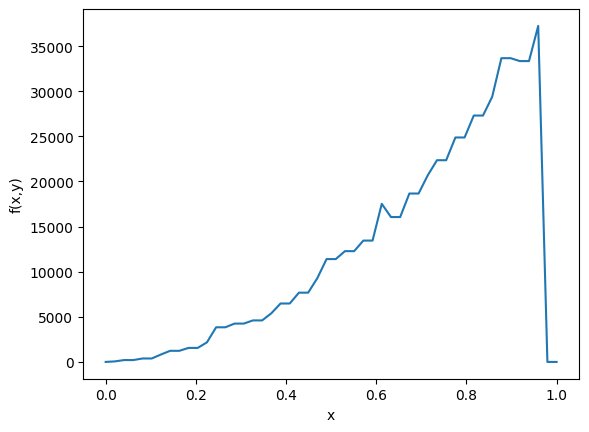

In [10]:
plt.plot(x,test_density)
plt.xlabel("x");
plt.ylabel("f(x,y)");
#plt.show();